In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import json
from matplotlib import patches, cm
from math import tan, atan, radians, degrees, cos, sin
from mpl_toolkits.mplot3d import Axes3D
import glob
import progressbar
from joblib import Parallel, delayed
from gta_math import *
from visualization import ids_to_greyscale, load_depth, show_bounding_boxes, load_stencil_ids, load_stencil_flags, \
get_bounding_boxes, show_loaded_bounding_boxes, get_detections, get_car_positions
import visualization

In [54]:
#in_directory = r'D:\projekty\GTA-V-extractors\sample-images'
in_directory = r'D:\generic-dataset'
#out_directory = r'D:\projekty\GTA-V-extractors\sample-images\output'

conn = visualization.get_connection_pooled()
cur = conn.cursor()

import visualization
visualization.multi_page = False
visualization.ini_file = 'gta-postprocessing.local.ini'
visualization.in_directory = in_directory


In [55]:
def get_base_name(name):
    return os.path.basename(os.path.splitext(name)[0])

def test_plane(X0, X1, X2, x, y, z):
    v1 = X1 - X0
    v2 = X2 - X0
    n = np.cross(v1, v2)
    
    return n[0] * (x - X0[0]) + n[1] * (y - X0[1]) + n[2] * (z - X0[2]) > 0


In [56]:
def draw3dbboxes(in_directory, out_directory, base_name):
    rgb_file = '{}/{}.jpg'.format(in_directory, base_name)
    json_file = '{}/{}.json'.format(in_directory, base_name)
    depth_file = '{}/{}-depth.png'.format(in_directory, base_name)
    stencil_file = '{}/{}-stencil.png'.format(in_directory, base_name)
    
    rgb = np.array(Image.open(rgb_file))
    depth = np.array(Image.open(depth_file))
    depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
    stencil = np.array(Image.open(stencil_file))
    with open(json_file, mode='r') as f:
        data = json.load(f)
    entities = data['entities']
    view_matrix = np.array(data['view_matrix'])
    proj_matrix = np.array(data['proj_matrix'])
    width = data['width']
    height = data['height']
    #visible_cars = [e for e in entities if e['bbox'][0] != [np.inf, np.inf] and e['type'] == 'car']
    visible_cars = [e for e in entities if e['class'] != 'Trains' and is_entity_in_image(depth, e, view_matrix, proj_matrix, width, height)]

    fig = plt.figure(figsize=(16, 10))
    plt.axis('off')
    plt.xlim([0, rgb.shape[1]])
    plt.ylim([rgb.shape[0], 0])
    ax = plt.gca()
    plt.imshow(rgb)

    for row in visible_cars:
        row['bbox_calc'] = calculate_2d_bbox(row, view_matrix, proj_matrix, width, height)
        # position in world coords
        pos = np.array(row['pos'])
        pixel_pos = world_coords_to_pixel(pos, view_matrix, proj_matrix, width, height)
        #plt.scatter(pixel_pos[0], pixel_pos[1])

        # bounding box
        bbox = np.array(row['bbox_calc'])
        bbox[:, 0] *= width
        bbox[:, 1] *= height
        bbox_width, bbox_height = bbox[0, :] - bbox[1, :]
        #rect = patches.Rectangle(bbox[1, :], bbox_width, bbox_height, linewidth=1, edgecolor='y', facecolor='none')
        #ax.add_patch(rect)

        # 3D bounding box
        rot = np.array(row['rot'])
        model_sizes = np.array(row['model_sizes'])
        points_3dbbox = get_model_3dbbox(model_sizes)

        # projecting cuboid to 2d
        bbox_2d = model_coords_to_pixel(pos, rot, points_3dbbox, view_matrix, proj_matrix, width, height).T
        #plt.scatter(bbox_2d[:, 0], bbox_2d[:, 1])
        
        # showing cuboid
        pol1 = patches.Polygon(bbox_2d[(0, 1, 3, 2), :], closed=True, linewidth=1, edgecolor='c', facecolor='none')  # fixed x
        pol2 = patches.Polygon(bbox_2d[(4, 5, 7, 6), :], closed=True, linewidth=1, edgecolor='c', facecolor='none')  # fixed x
        pol3 = patches.Polygon(bbox_2d[(0, 2, 6, 4), :], closed=True, linewidth=1, edgecolor='c', facecolor='none')  # fixed z
        pol4 = patches.Polygon(bbox_2d[(1, 3, 7, 5), :], closed=True, linewidth=1, edgecolor='c', facecolor='none')  # fixed z
        pol5 = patches.Polygon(bbox_2d[(0, 1, 5, 4), :], closed=True, linewidth=1, edgecolor='r', facecolor='none')  # fixed y
        pol6 = patches.Polygon(bbox_2d[(2, 3, 7, 6), :], closed=True, linewidth=1, edgecolor='g', facecolor='none')  # fixed y
        ax.add_patch(pol1)
        ax.add_patch(pol2)
        ax.add_patch(pol3)
        ax.add_patch(pol4)
        ax.add_patch(pol5)
        ax.add_patch(pol6)
    
    plt.show()
    #plt.savefig('{}/{}.jpg'.format(out_directory, base_name), bbox_inches='tight')

In [57]:
def draw_car_pixels(in_directory, out_directory, base_name):
    rgb_file = '{}/{}.jpg'.format(in_directory, base_name)
    json_file = '{}/{}.json'.format(in_directory, base_name)
    depth_file = '{}/{}-depth.png'.format(in_directory, base_name)
    stencil_file = '{}/{}-stencil.png'.format(in_directory, base_name)
    
    rgb = np.array(Image.open(rgb_file))
    depth = np.array(Image.open(depth_file))
    depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
    stencil = np.array(Image.open(stencil_file))
    with open(json_file, mode='r') as f:
        data = json.load(f)
    entities = data['entities']
    view_matrix = np.array(data['view_matrix'])
    proj_matrix = np.array(data['proj_matrix'])
    width = data['width']
    height = data['height']
    #visible_cars = [e for e in entities if e['bbox'][0] != [np.inf, np.inf] and e['type'] == 'car']
    visible_cars = [e for e in entities if e['class'] != 'Trains' and is_entity_in_image(depth, e, view_matrix, proj_matrix, width, height)]

    params = {
        'width': width,
        'height': height,
        'proj_matrix': proj_matrix,
        'cam_far_clip': 100,
    }
    pts, _ = points_to_homo(params, depth, False)    # False to get all pixels
    pts_p = ndc_to_view(pts, proj_matrix)
    pixel_3d = view_to_world(pts_p, view_matrix)
    pixel_3d = np.reshape(pixel_3d, (4, height, width))
    pixel_3d = pixel_3d[0:3, ::]

    cc, rr = np.meshgrid(range(width), range(height))
    car_id_mask = np.zeros([height, width])
    car_mask = np.bitwise_and(stencil, 7) == 2

    plt.figure(figsize=(16, 10))
    plt.axis('off')
    plt.xlim([0, rgb.shape[1]])
    plt.ylim([rgb.shape[0], 0])

    id = 1
    for row in visible_cars:
        row['bbox_calc'] = calculate_2d_bbox(row, view_matrix, proj_matrix, width, height)
        # position in world coords
        pos = np.array(row['pos'])
        rot = np.array(row['rot'])

        model_sizes = np.array(row['model_sizes'])
        points_3dbbox = get_model_3dbbox(model_sizes)

        # 3D bounding box
        # projecting cuboid to 2d
        bbox_3d = model_coords_to_world(pos, rot, points_3dbbox, view_matrix, proj_matrix, width, height)

        # bounding box
        bbox = np.array(row['bbox_calc'])
        bbox[:, 0] *= width
        bbox[:, 1] *= height
        bbox_width, bbox_height = bbox[0, :] - bbox[1, :]

        bbox = np.array([[np.ceil(bbox[0, 0]), np.floor(bbox[0, 1])],
                         [np.ceil(bbox[1, 0]), np.floor(bbox[1, 1])]]).astype(int)

        # points inside the 2D bbox with car mask on
        idxs = np.where((car_mask == True) & (cc >= bbox[1, 0]) & (cc <= bbox[0, 0]) & (rr >= bbox[1, 1]) & (rr <= bbox[0, 1]))

        # 3D coordinates of pixels in idxs
        x = pixel_3d[0, ::].squeeze()[idxs]
        y = pixel_3d[1, ::].squeeze()[idxs]
        z = pixel_3d[2, ::].squeeze()[idxs]

        # test if the points lie inside 3D bbox
        in1 = test_plane(bbox_3d[3, :], bbox_3d[2, :], bbox_3d[7, :], x, y, z)
        in2 = test_plane(bbox_3d[1, :], bbox_3d[5, :], bbox_3d[0, :], x, y, z)
        in3 = test_plane(bbox_3d[6, :], bbox_3d[2, :], bbox_3d[4, :], x, y, z)
        in4 = test_plane(bbox_3d[3, :], bbox_3d[7, :], bbox_3d[1, :], x, y, z)
        in5 = test_plane(bbox_3d[7, :], bbox_3d[6, :], bbox_3d[5, :], x, y, z)
        in6 = test_plane(bbox_3d[0, :], bbox_3d[2, :], bbox_3d[1, :], x, y, z)
        is_inside = in1 & in2 & in3 & in4 & in5 & in6
        
        rgb[(idxs[0][is_inside], idxs[1][is_inside])] = np.array(cm.viridis(id * 25)[0:3]) * 255
    
        id += 1
        # assuming there are no more than 10 cars in image
#    plt.imshow(car_id_mask)
#    plt.clim(0.1, 1)
    plt.imshow(rgb)
    #plt.savefig('{}/{}.jpg'.format(out_directory, base_name), bbox_inches='tight')
    plt.show()


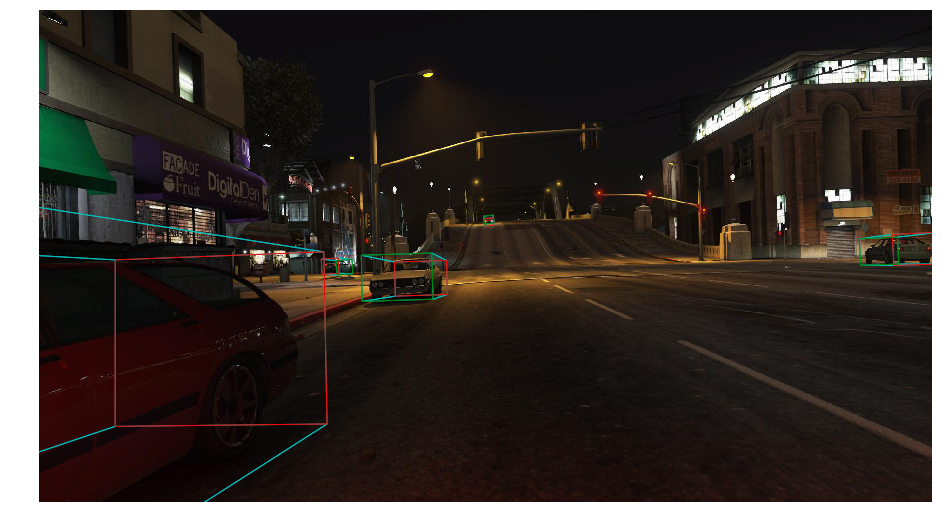

In [58]:
base_name = '2018-03-30--02-02-25--188'
draw3dbboxes(in_directory, out_directory, base_name)

In [59]:
pattern = '[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]--[0-9][0-9]-[0-9][0-9]-[0-9][0-9]--[0-9][0-9][0-9].jpg'
files = glob.glob(os.path.join(in_directory, pattern))
print('there are {} files'.format(len(files)))


there are 122960 files


In [60]:
for name in files:
    print(name)
    draw3dbboxes(in_directory, out_directory, get_base_name(name))

D:\generic-dataset\2018-03-07--15-18-07--517.jpg


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\generic-dataset/2018-03-07--15-18-07--517-depth.png'

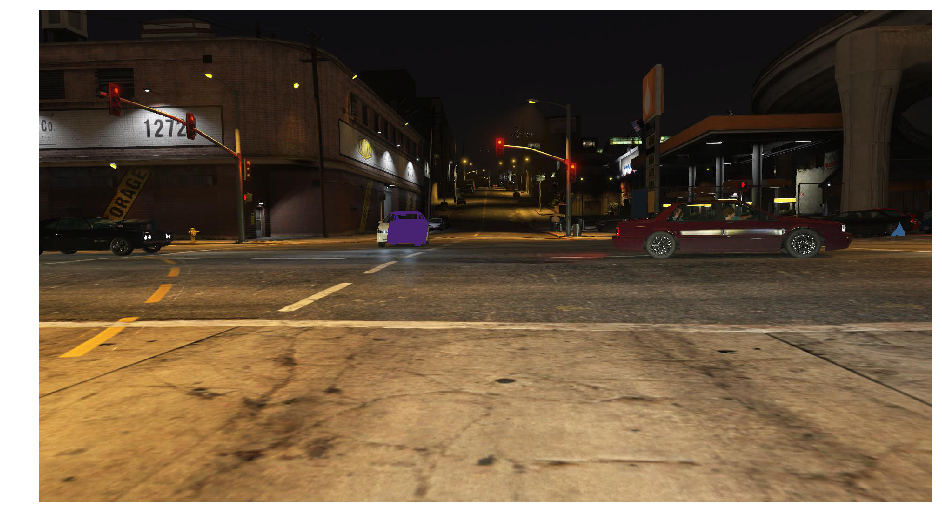

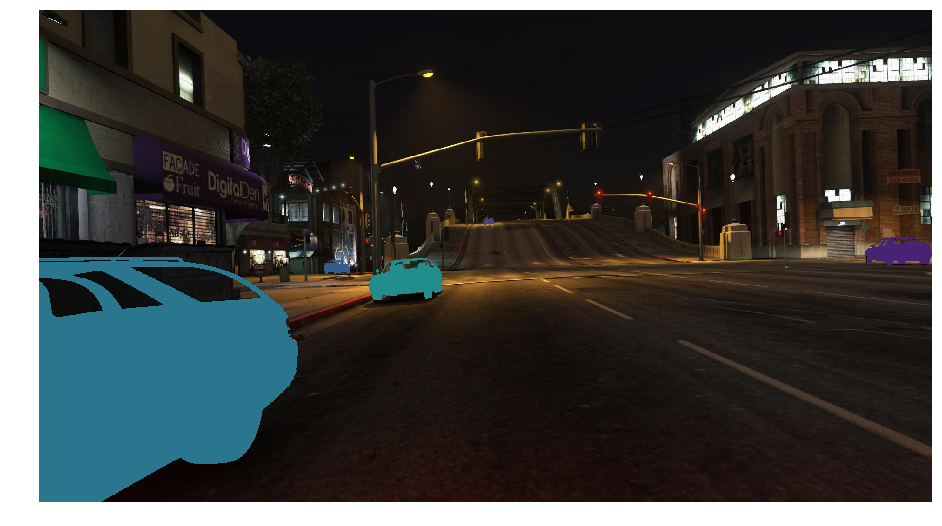

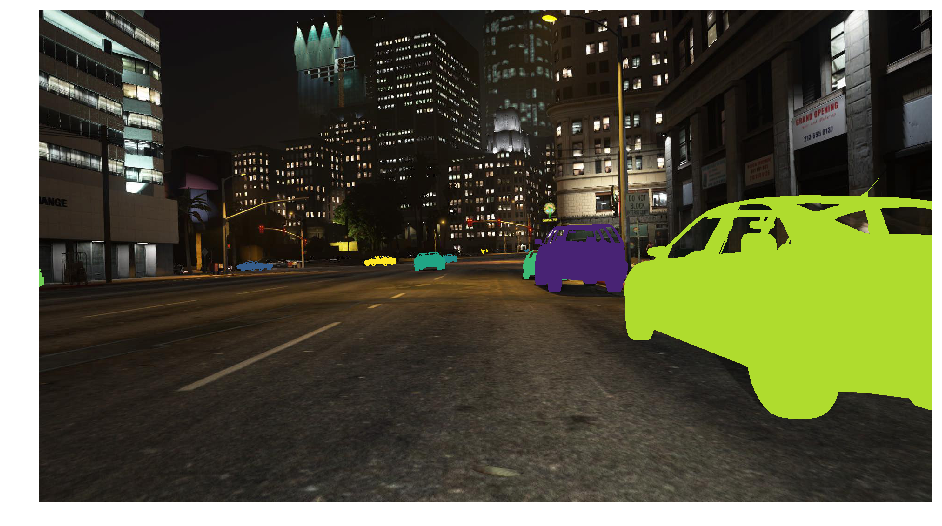

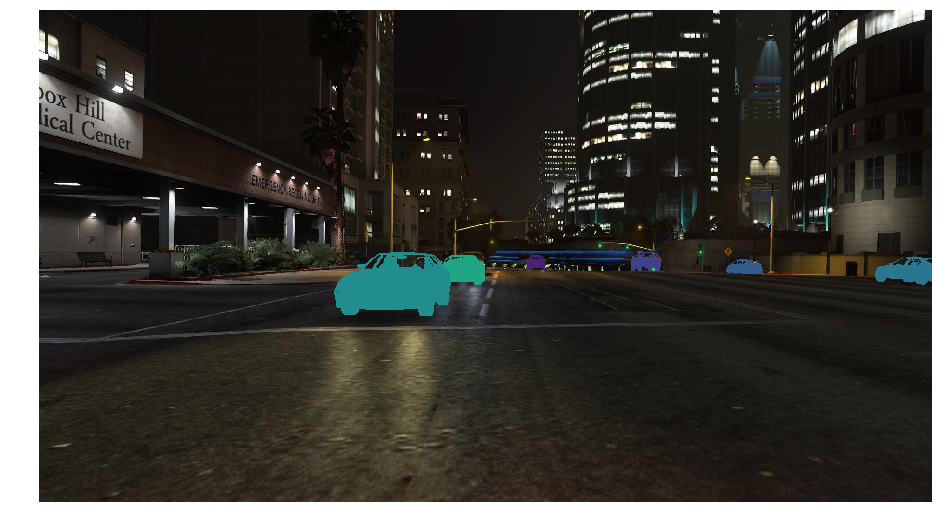

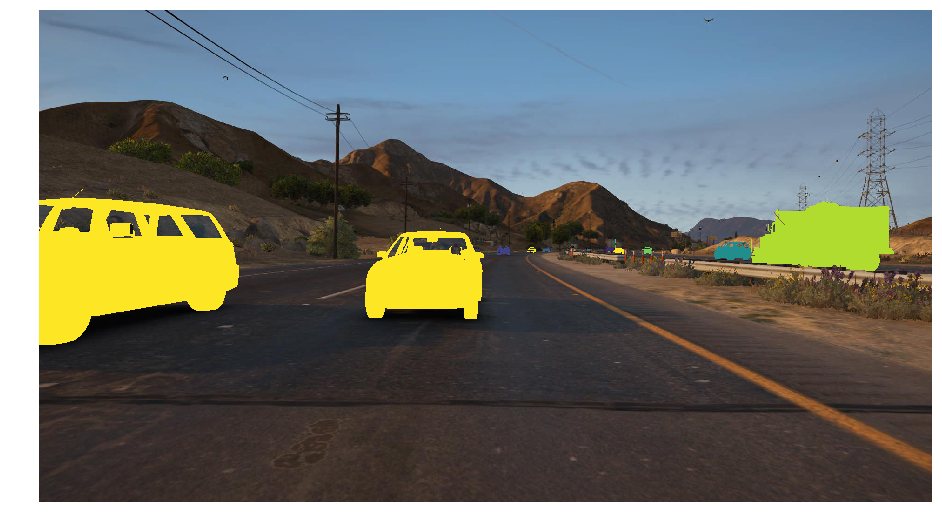

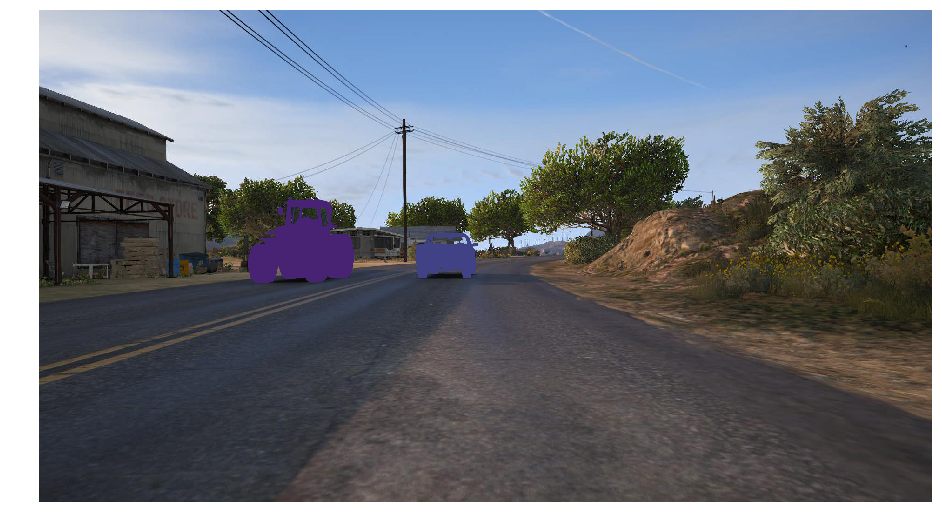

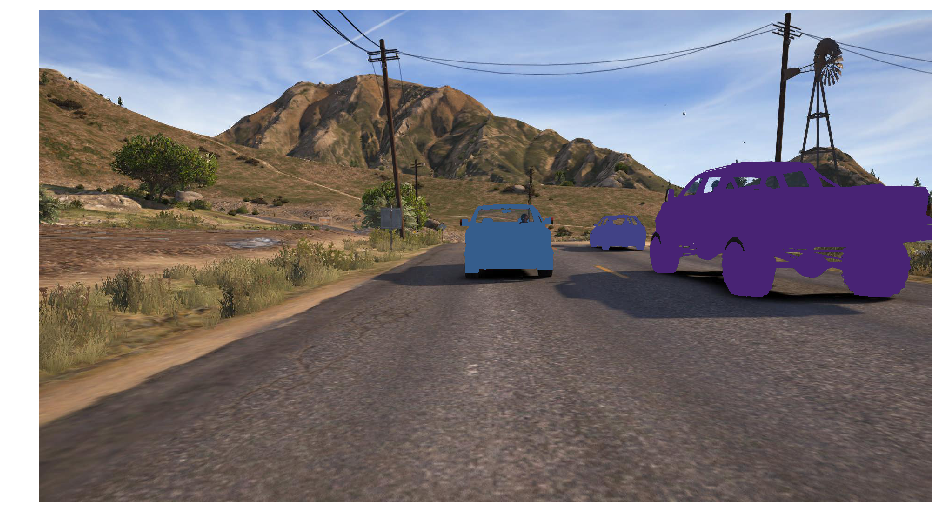

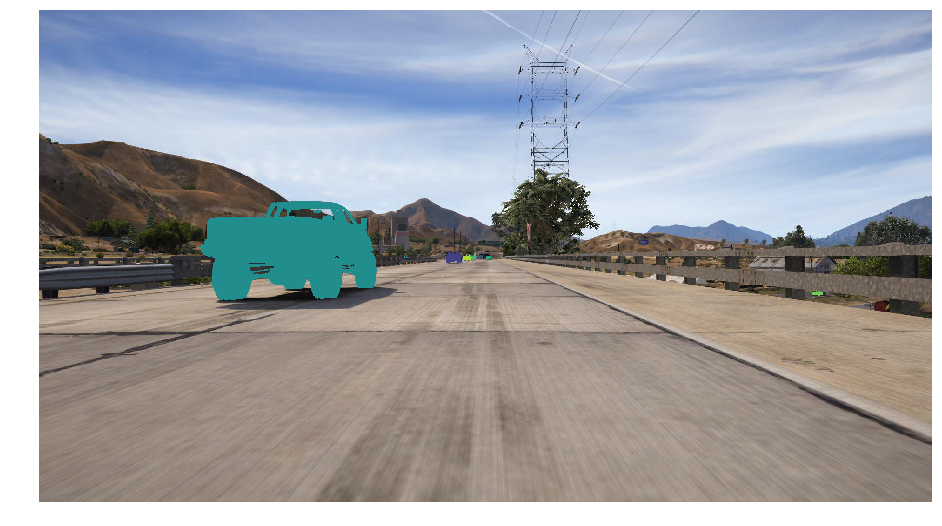

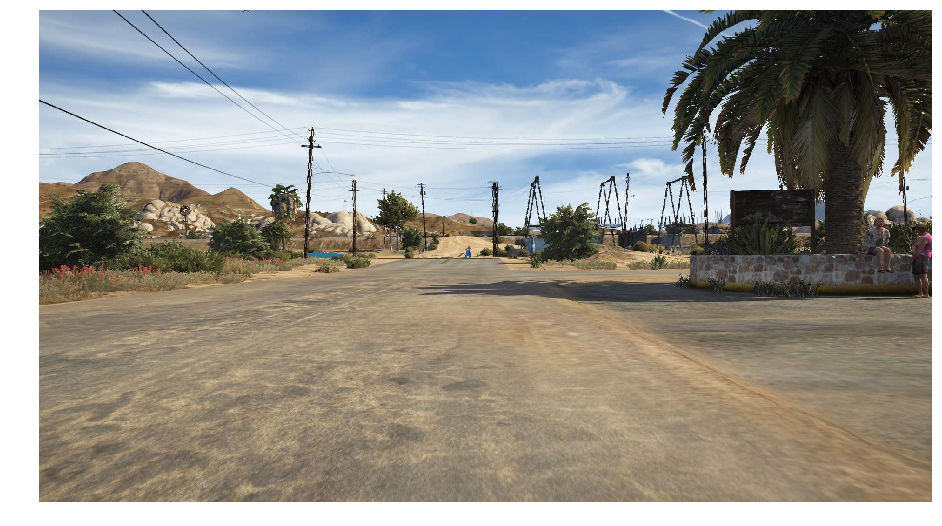

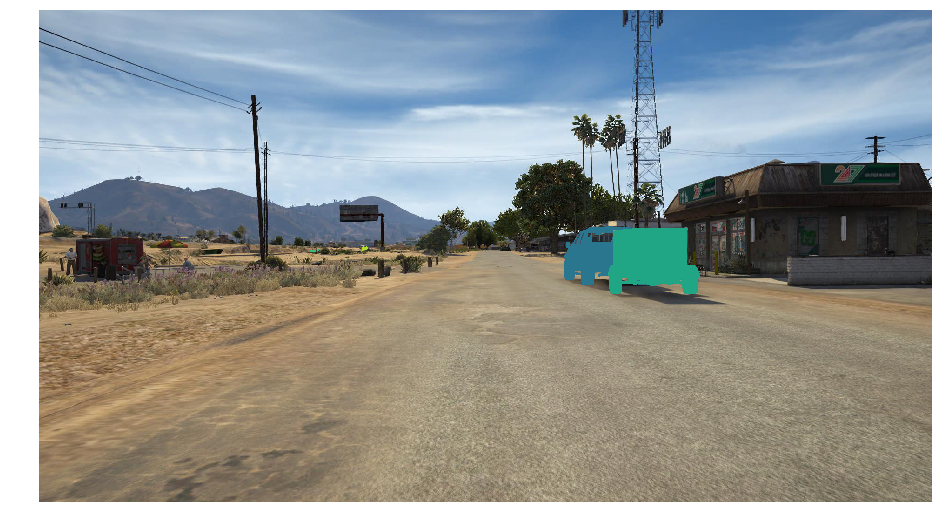

In [9]:
for name in files:
    draw_car_pixels(in_directory, out_directory, get_base_name(name))

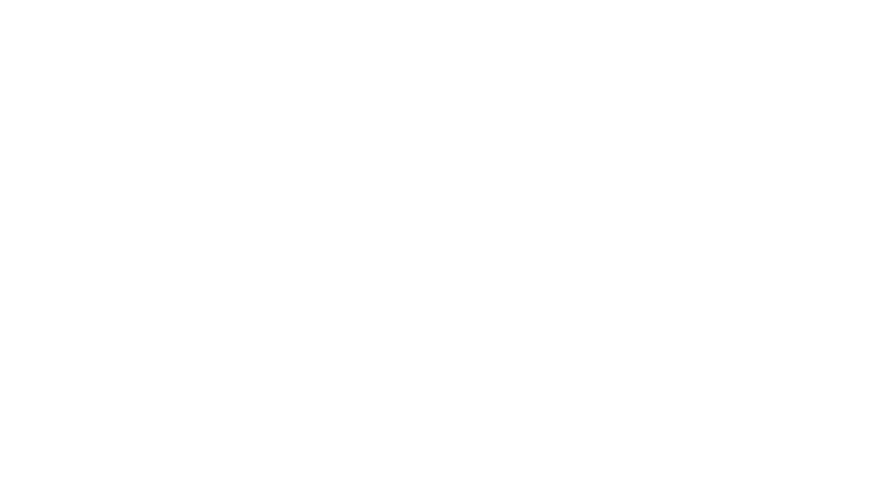

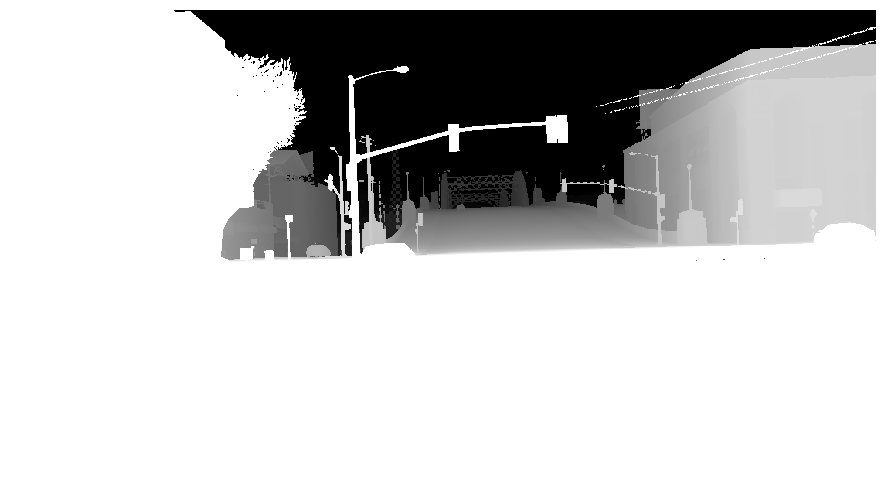

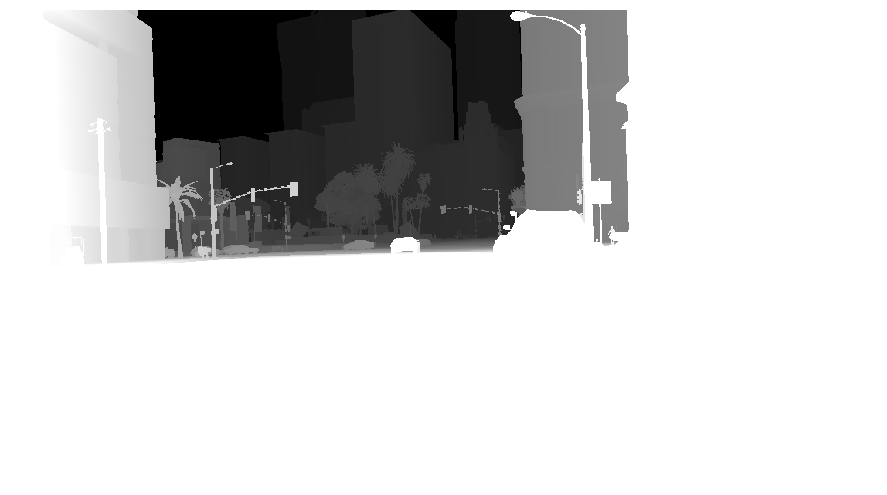

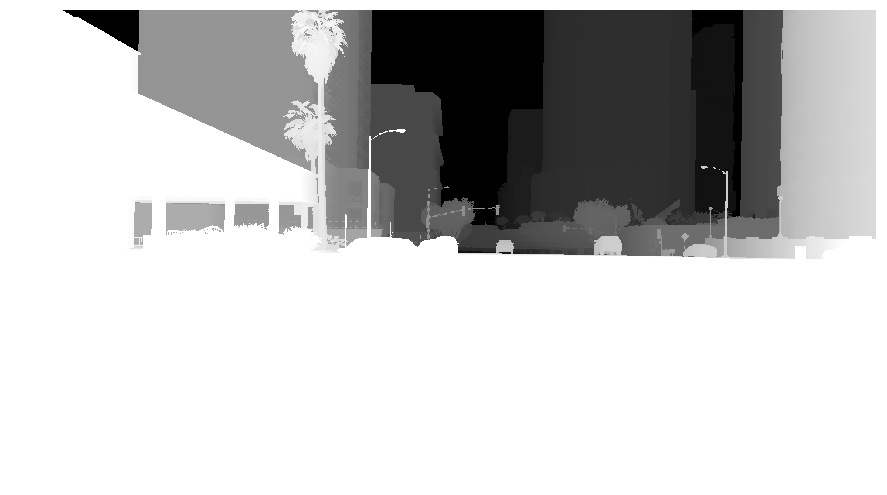

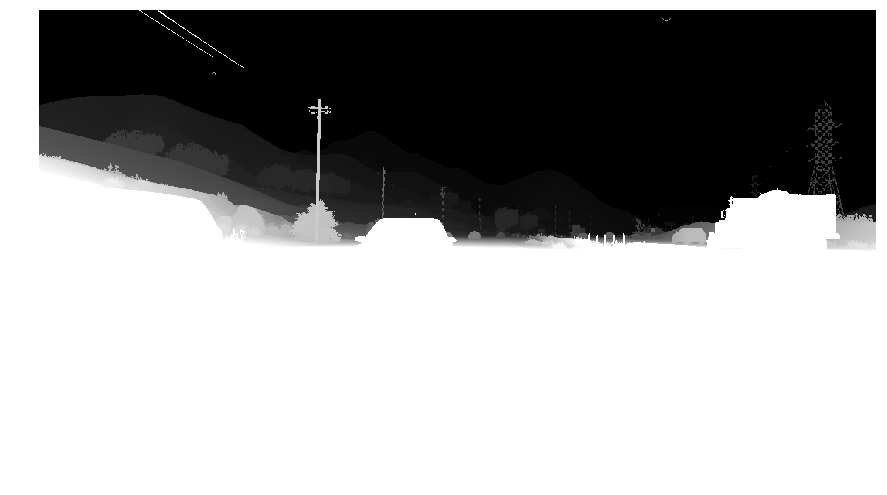

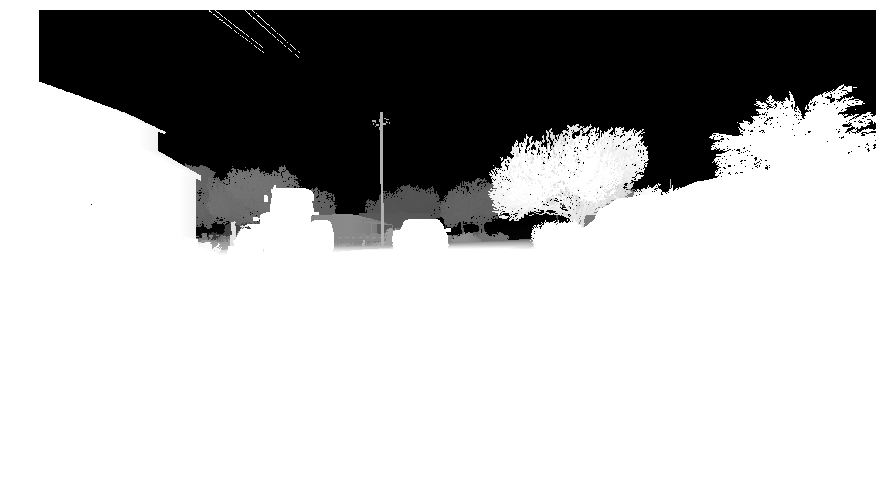

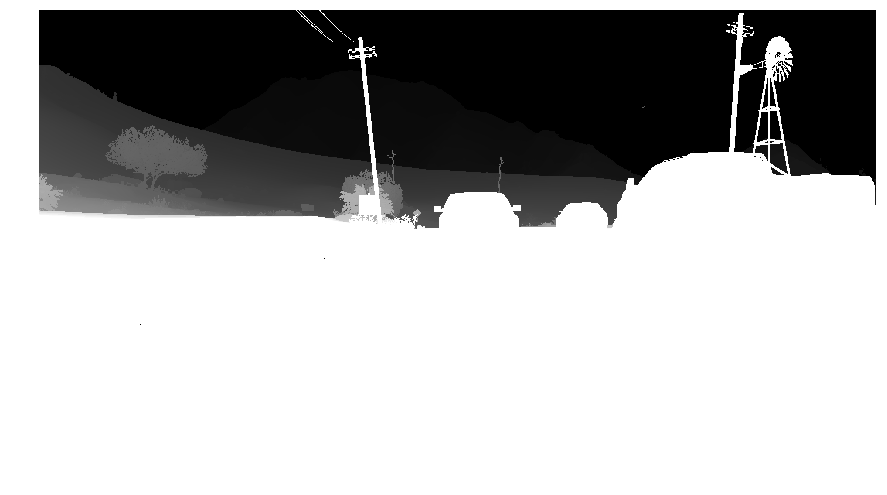

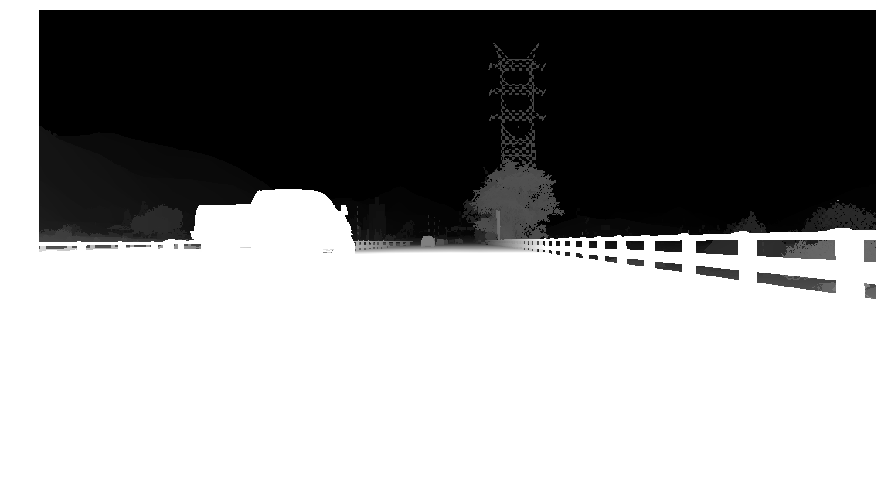

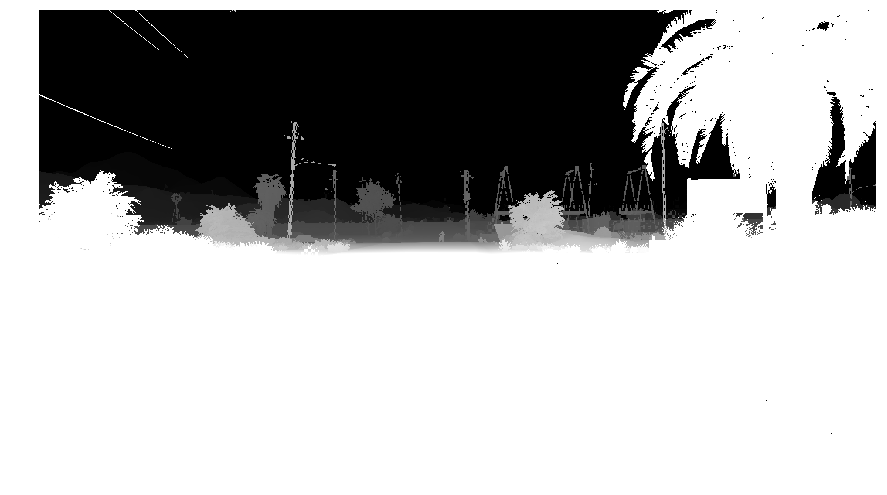

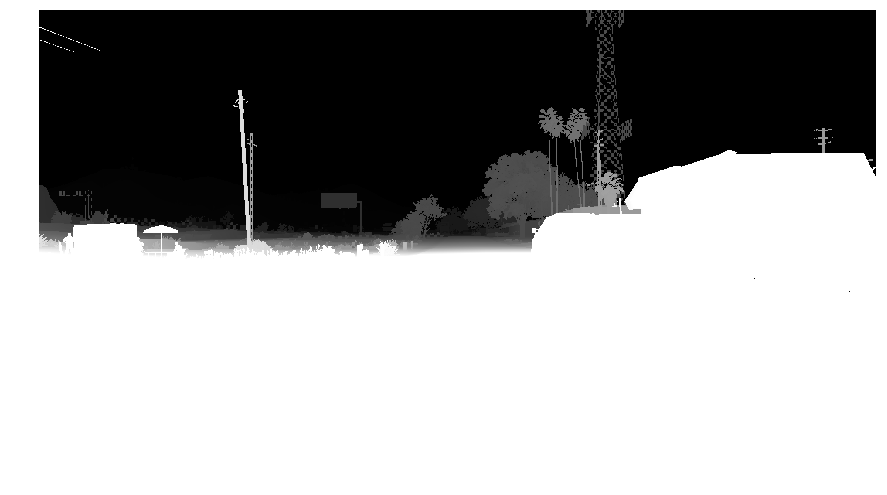

In [18]:
for name in files:
    depth = Image.open(os.path.join(in_directory, get_base_name(name)+'-depth.png'))
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(depth, cmap='gray')
    plt.show()

In [52]:

def find_points_for_car(in_directory, handle):
    positions = []
    pattern = '[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]--[0-9][0-9]-[0-9][0-9]-[0-9][0-9]--[0-9][0-9][0-9].json'
    files = glob.glob(os.path.join(in_directory, pattern))
    for file in files:
        json_file = '{}/{}.json'.format(in_directory, get_base_name(file))
        if json_file in jsons:
            entities = jsons[json_file]
        else:
            with open(json_file, mode='r') as f:
                data = json.load(f)
                entities = data['entities']
                jsons[json_file] = entities
        frame_position = [i['pos'] for i in entities if i['handle'] == handle]
        if len(frame_position) == 0:
            continue
        positions.append(frame_position)
    return positions
    

def draw_trajectories(in_directory, base_name):
    rgb_file = '{}/{}.jpg'.format(in_directory, base_name)
    json_file = '{}/{}.json'.format(in_directory, base_name)
    depth_file = '{}/{}-depth.png'.format(in_directory, base_name)
    stencil_file = '{}/{}-stencil.png'.format(in_directory, base_name)
    
    rgb = np.array(Image.open(rgb_file))
    depth = np.array(Image.open(depth_file))
    depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
    stencil = np.array(Image.open(stencil_file))
    with open(json_file, mode='r') as f:
        data = json.load(f)
    entities = data['entities']
    view_matrix = np.array(data['view_matrix'])
    proj_matrix = np.array(data['proj_matrix'])
    width = data['width']
    height = data['height']
    #visible_cars = [e for e in entities if e['bbox'][0] != [np.inf, np.inf] and e['type'] == 'car']
    visible_cars = [e for e in entities if e['class'] != 'Trains' and is_entity_in_image(depth, e, view_matrix, proj_matrix, width, height)]

    params = {
        'width': width,
        'height': height,
        'proj_matrix': proj_matrix,
        'cam_far_clip': 100,
    }
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(rgb)
    
    print('{} visible vehicles:'.format(len(visible_cars)))
    for row in visible_cars:
        positions = np.array(get_car_positions(row['handle'], 19, data['snapshot_id'], 200))
        print('handle: {}, positions len: {}'.format(row['handle'], len(positions)))
        positions = np.hstack((positions, np.ones((positions.shape[0], 1)))).T
        view_positions = view_matrix @ positions
        # filtering based on view coords, keeping only point belonging to correct half-space
        view_positions = view_positions[:, view_positions[2, :] < 0]
        ndc_poss = proj_matrix @ view_positions
        ndc_poss /= ndc_poss[3, :]
        ndc_poss = ndc_poss.T
        in_image = ndc_poss[(ndc_poss[:, 0] > -1) & (ndc_poss[:, 0] < 1) & (ndc_poss[:, 1] > -1) & (ndc_poss[:, 1] < 1)]
        pixels = ndcs_to_pixels(in_image[:, 0:2].T, (height, width)).T
        plt.plot(pixels[:, 1], pixels[:, 0], 'o', ms=1)
        
    plt.show()

13 visible vehicles:
handle: 519689, positions len: 399
handle: 358921, positions len: 399
handle: 493833, positions len: 399
handle: 582409, positions len: 399
handle: 535817, positions len: 390
handle: 283657, positions len: 399
handle: 175881, positions len: 399
handle: 253193, positions len: 399
handle: 640265, positions len: 362
handle: 562953, positions len: 305
handle: 275721, positions len: 399
handle: 580873, positions len: 399
handle: 483593, positions len: 399


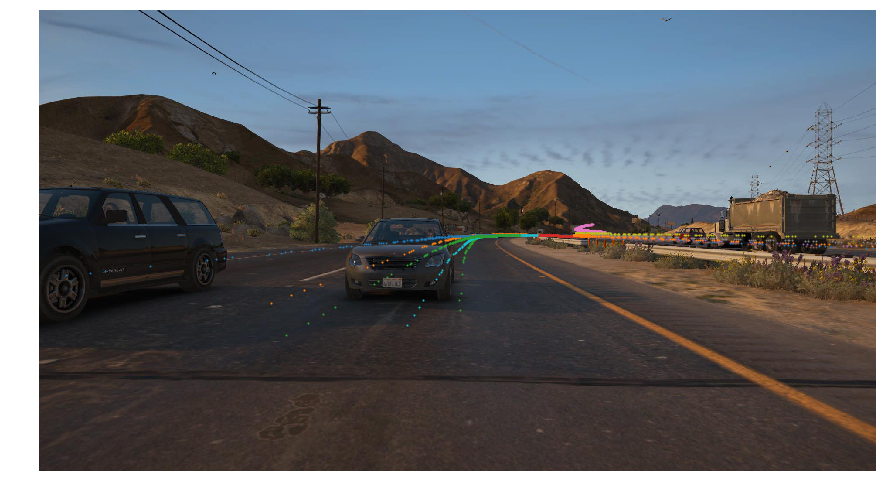

In [53]:
#base_name = '2018-03-30--02-38-26--367'
base_name = '2018-03-30--04-00-54--651'
draw_trajectories('D:\generic-dataset', base_name)

In [15]:
len(jsons)

NameError: name 'jsons' is not defined

In [27]:
rgb_file = '{}/{}.jpg'.format('D:\generic-dataset', base_name)
json_file = '{}/{}.json'.format('D:\generic-dataset', base_name)
depth_file = '{}/{}-depth.png'.format('D:\generic-dataset', base_name)
stencil_file = '{}/{}-stencil.png'.format('D:\generic-dataset', base_name)
    
rgb = np.array(Image.open(rgb_file))
depth = np.array(Image.open(depth_file))
depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
stencil = np.array(Image.open(stencil_file))
with open(json_file, mode='r') as f:
    data = json.load(f)
entities = data['entities']
view_matrix = np.array(data['view_matrix'])
proj_matrix = np.array(data['proj_matrix'])
width = data['width']
height = data['height']
visible_cars = [e for e in data['entities'] if e['class'] != 'Trains' and is_entity_in_image(depth, e, view_matrix, proj_matrix, width, height)]
car = visible_cars[1]
    
positions = np.array(get_car_positions(car['handle'], 19, data['snapshot_id'], 100))
print('handle: {}, positions len: {}'.format(car['handle'], len(positions)))
positions = np.hstack((positions, np.ones((positions.shape[0], 1)))).T
view_positions = view_matrix @ positions
# filtering based on view coords, keeping only point belonging to correct half-space
view_positions = view_positions[:, view_positions[2, :] < 0]
ndc_poss = proj_matrix @ view_positions
ndc_poss /= ndc_poss[3, :]
ndc_poss = ndc_poss.T
# filtering based on NDC boundaries
in_image = ndc_poss[(ndc_poss[:, 0] > -1) & (ndc_poss[:, 0] < 1) & (ndc_poss[:, 1] > -1) & (ndc_poss[:, 1] < 1)]
print('positions in image len: {}'.format(len(in_image)))
pixels = ndcs_to_pixels(in_image[:, 0:2].T, (height, width)).T


handle: 358921, positions len: 199
positions in image len: 179


In [24]:
print('current world positions:', car['pos'])
#display(positions[0:3, :].T)
display(view_positions[0:3, :].T)
display(view_positions[2, :] < 0)
display(pixels)


current world positions: [2936.51513671875, 3955.87158203125, 51.5198860168457]


array([[  1.99867295e+01,   2.02800132e+00,  -1.73978624e+02],
       [  1.93361948e+01,   2.00654557e+00,  -1.71606737e+02],
       [  1.91967100e+01,   2.00164593e+00,  -1.71088029e+02],
       [  1.90857668e+01,   1.99774684e+00,  -1.70675521e+02],
       [  1.89737966e+01,   1.99260683e+00,  -1.70283253e+02],
       [  1.83328897e+01,   1.96914378e+00,  -1.67777708e+02],
       [  1.82083064e+01,   1.96508898e+00,  -1.67323961e+02],
       [  1.81023892e+01,   1.96032161e+00,  -1.66867582e+02],
       [  1.80170268e+01,   1.95647850e+00,  -1.66499417e+02],
       [  1.74351174e+01,   1.93107168e+00,  -1.64063831e+02],
       [  1.73348009e+01,   1.92642040e+00,  -1.63630467e+02],
       [  1.72087725e+01,   1.92172747e+00,  -1.63151037e+02],
       [  1.70926183e+01,   1.92378724e+00,  -1.62709138e+02],
       [  1.65310184e+01,   1.89901835e+00,  -1.60456599e+02],
       [  1.64352170e+01,   1.89374793e+00,  -1.60037992e+02],
       [  1.63312516e+01,   1.88802945e+00,  -1.5958368

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

array([[ 514, 1089],
       [ 514, 1087],
       [ 514, 1086],
       [ 514, 1086],
       [ 514, 1085],
       [ 514, 1083],
       [ 514, 1082],
       [ 514, 1082],
       [ 514, 1082],
       [ 514, 1079],
       [ 514, 1079],
       [ 514, 1078],
       [ 514, 1078],
       [ 514, 1076],
       [ 514, 1075],
       [ 514, 1075],
       [ 514, 1074],
       [ 514, 1072],
       [ 514, 1072],
       [ 514, 1071],
       [ 514, 1071],
       [ 514, 1069],
       [ 514, 1068],
       [ 514, 1068],
       [ 514, 1067],
       [ 514, 1065],
       [ 514, 1064],
       [ 514, 1064],
       [ 514, 1063],
       [ 514, 1061],
       [ 514, 1061],
       [ 514, 1060],
       [ 514, 1060],
       [ 514, 1058],
       [ 514, 1057],
       [ 514, 1057],
       [ 514, 1056],
       [ 514, 1054],
       [ 514, 1054],
       [ 514, 1053],
       [ 514, 1053],
       [ 514, 1051],
       [ 514, 1050],
       [ 514, 1049],
       [ 514, 1049],
       [ 514, 1046],
       [ 514, 1046],
       [ 514,

In [19]:
positions.shape

(0,)